In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import os
PATH_TO_COSQL = os.environ['COSQL_PATH']

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# User Intent Prediction

In [5]:
class User_Intent:

    keys = ["database_id","utterance","utterance_toks","intent"]
    
    def __init__(self, filename):
        with open(filename, 'r') as f:
            self.lst = json.load(f)
        self.count = len(self.lst)
    
    def get_dbid(self): # Get all database_id
        dbid = []
        for data in self.lst:
            dbid.append(data["database_id"])
        return pd.Series(dbid)
    
    def get_intents_num(self): # Get all intents_num
        intents_num = []
        for data in self.lst:
            if data["intent"]:
                intents_num.append(len(data["intent"]))
            else:
                intents_num.append(0)
        return pd.Series(intents_num)

    def get_intents(self): # Get all intents
        intents = []
        for data in self.lst:
            if data["intent"]:
                intents += data["intent"]
        return pd.Series(intents)

    def intents_coocurence_matrix(self): # intents_coocurence_matrix
        intents = list(set(self.get_intents()))
        n = len(intents)
        df = pd.DataFrame(np.zeros((n,n)), 
                  index=intents,# raw name
                  columns=intents)# column name
        for data in self.lst:
            s = data["intent"]
            if s and len(s)>1:
                for i in range(len(s)-1):
                    for j in range(i+1, len(s)):
                        df[s[i]][s[j]] += 1
                        df[s[j]][s[i]] += 1
        return df

    def get_utter_toks_nums(self): # Get all utterance_toks's length
        toks_nums = []
        for data in self.lst:
            toks_nums.append(len(data["utterance_toks"]))
        return pd.Series(toks_nums)
    
    def cor_intents_w_utter_toks_nums(self): # Distribution of utterance_toks's length grouped by different intent
        dic = dict()
        for data in self.lst:
            if data["intent"]:
                for intent in data["intent"]:
                    dic[intent] = dic.get(intent,[]) + [len(data["utterance_toks"])]
        return dic

    def get_all_utter(self): # Get all utter
        utters = ""
        for data in self.lst:
            utters += data["utterance"]
        return utters

## Development dataset

In [7]:
dev = User_Intent(f"{PATH_TO_COSQL}/user_intent_prediction/cosql_dev.json")
# sample amount
dev.count

1507

In [8]:
# database_id occurence count
dev.get_dbid().value_counts()

world_1                         195
dog_kennels                     162
car_1                           145
student_transcripts_tracking    125
flight_2                         91
wta_1                            89
network_1                        85
cre_Doc_Template_Mgt             75
concert_singer                   72
museum_visit                     67
pets_1                           61
tvshow                           59
poker_player                     57
employee_hire_evaluation         47
battle_death                     43
singer                           40
course_teach                     33
orchestra                        31
voter_1                          19
real_estate_properties           11
Name: count, dtype: int64

In [9]:
# intents number of every sample
dev.get_intents_num().value_counts().sort_index()

0       4
1    1455
2      46
3       2
Name: count, dtype: int64

In [10]:
# number of different intents (apart from missing value for intents)
dev.get_intents().value_counts()

INFORM_SQL           980
THANK_YOU            298
AMBIGUOUS            107
AFFIRM                57
INFER_SQL             52
CANNOT_ANSWER         20
GOOD_BYE              14
GREETING               8
NEGATE                 8
CANNOT_UNDERSTAND      7
NOT_RELATED            2
Name: count, dtype: int64

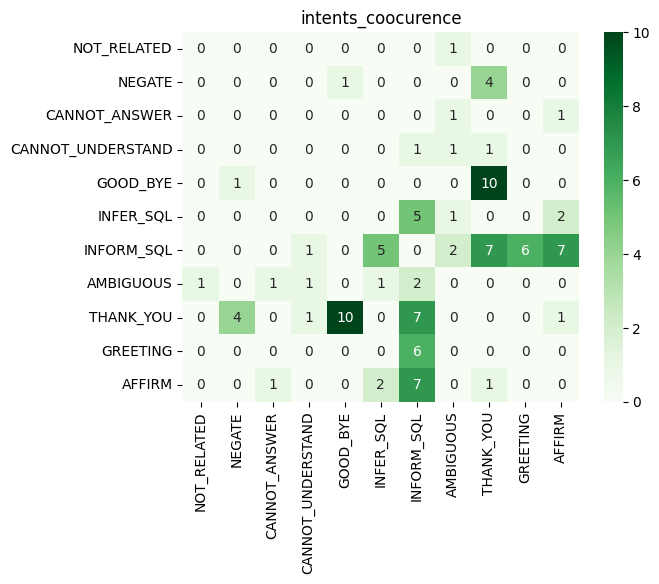

In [11]:
# intents coocurence heatmap
data = dev.intents_coocurence_matrix()
sns.heatmap(data=data,annot=True,cmap=plt.get_cmap('Greens'))
plt.title('intents_coocurence');

count    1507.00
mean        8.47
std         5.51
min         1.00
25%         4.00
50%         8.00
75%        11.00
max        39.00
dtype: float64

<BarContainer object of 31 artists>

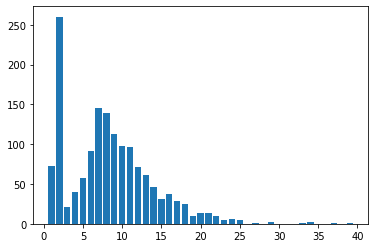

In [10]:
# number of toks of every utterance
data = dev.get_utter_toks_nums()
data.describe().round(2)
value_count = data.value_counts()
plt.bar(value_count.keys(),value_count)
plt.show()

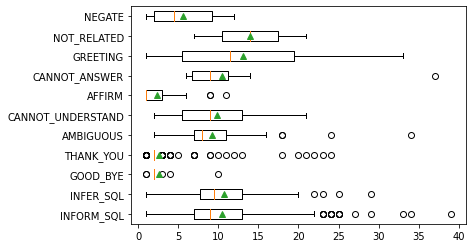

In [11]:
# number of utterance toks with different intent
data = dev.cor_intents_w_utter_toks_nums()
plt.boxplot(data.values(), labels = data.keys(), vert=False, showmeans=True)
plt.show();

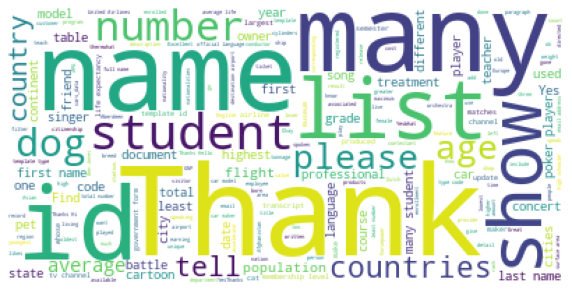

In [12]:
# utterance wordcloud
data = dev.get_all_utter()
wordcloud = WordCloud(background_color="white").generate(data)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

## Training dataset

In [13]:
train = User_Intent("user_intent_prediction\cosql_train.json")
# sample amount
train.count

11228

In [14]:
# database_id occurence count
train.get_dbid().value_counts()

college_2                        286
college_1                        276
store_1                          245
department_store                 223
baseball_1                       212
                                ... 
program_share                     28
customers_campaigns_ecommerce     27
workshop_paper                    19
company_1                          9
music_2                            4
Length: 140, dtype: int64

In [15]:
# intents number of every sample
train.get_intents_num().value_counts().sort_index()

0       38
1    10814
2      373
3        3
dtype: int64

In [16]:
# number of different intents (apart from missing value for intents)
train.get_intents().value_counts()

INFORM_SQL           7061
THANK_YOU            2216
AMBIGUOUS             875
AFFIRM                538
INFER_SQL             371
CANNOT_ANSWER         184
GOOD_BYE               95
GREETING               64
CANNOT_UNDERSTAND      59
NOT_RELATED            57
NEGATE                 45
addtion                 1
INFORM_SQL:             1
sorry                   1
dtype: int64

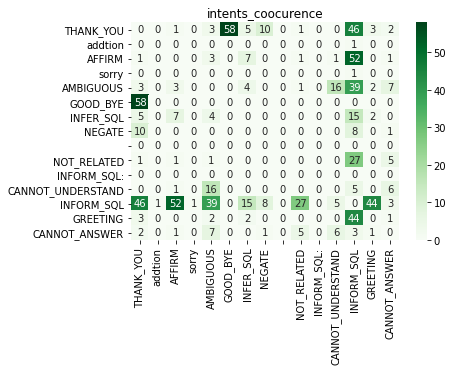

In [17]:
# intents coocurence heatmap
data = train.intents_coocurence_matrix()
sns.heatmap(data=data,annot=True,cmap=plt.get_cmap('Greens'))
plt.title('intents_coocurence');

count    11228.00
mean         8.66
std          5.73
min          1.00
25%          4.00
50%          8.00
75%         12.00
max         57.00
dtype: float64

<BarContainer object of 44 artists>

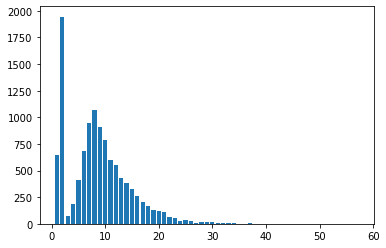

In [18]:
# number of toks of every utterance
data = train.get_utter_toks_nums()
data.describe().round(2)
value_count = data.value_counts()
plt.bar(value_count.keys(),value_count)
plt.show()

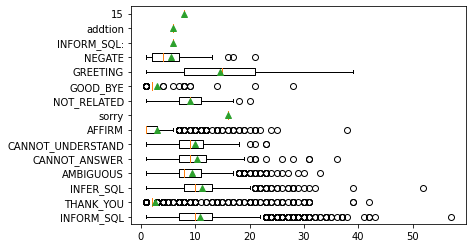

In [19]:
# number of utterance toks with different intent
data = train.cor_intents_w_utter_toks_nums()
plt.boxplot(data.values(), labels = data.keys(), vert=False, showmeans=True)
plt.show();

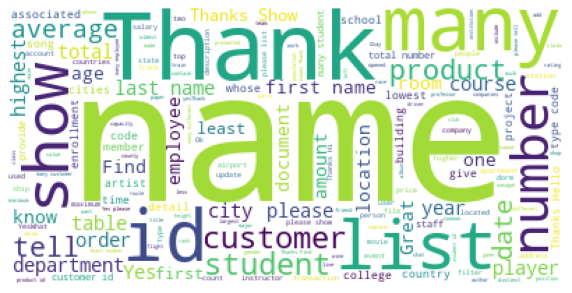

In [20]:
# utterance wordcloud
data = train.get_all_utter()
wordcloud = WordCloud(background_color="white").generate(data)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# SQL State Tracking

In [21]:
class SQL_State:

    keys = {"final":["utterance","query"],"database_id":None,\
            "interaction":["utterance","utterance_toks","query","query_toks_no_value","sql"]}
    
    def __init__(self, filename):
        with open(filename, 'r') as f:
            self.lst = json.load(f)
        self.count = len(self.lst)
    
    def get_dbid(self): # Get all database_id
        dbid = []
        for data in self.lst:
            dbid.append(data["database_id"])
        return pd.Series(dbid)
    
    def get_interaction_num(self): # Get all interaction_num
        interaction_num = []
        for data in self.lst:
            interaction_num.append(len(data["interaction"]))
        return pd.Series(interaction_num)

    def get_utter_query_toks_len(self): # Get all utter_query_toks_len
        dt = {"utter_tok_num":[],"query_tok_num":[]}
        for data in self.lst:
            for rnd in data["interaction"]:
                dt["utter_tok_num"].append(len(rnd["utterance_toks"]))
                dt["query_tok_num"].append(len(rnd["query_toks_no_value"]))
        return pd.DataFrame.from_dict(dt)

    def get_all_utter(self): # Get all utter
        utters = ""
        for data in self.lst:
            for rnd in data["interaction"]:
                utters += rnd["utterance"]
        return utters

## Development dataset

In [22]:
dev = SQL_State("sql_state_tracking\cosql_dev.json")
# sample amount
dev.count

293

In [23]:
# database_id occurence count
dev.get_dbid().value_counts()

world_1                         35
dog_kennels                     30
car_1                           30
student_transcripts_tracking    25
flight_2                        19
wta_1                           17
cre_Doc_Template_Mgt            15
network_1                       14
concert_singer                  14
pets_1                          13
museum_visit                    13
tvshow                          13
poker_player                    12
employee_hire_evaluation        10
battle_death                     8
course_teach                     7
singer                           7
orchestra                        6
voter_1                          3
real_estate_properties           2
dtype: int64

count    293.00
mean       3.44
std        1.20
min        1.00
25%        3.00
50%        3.00
75%        4.00
max        9.00
dtype: float64

<BarContainer object of 9 artists>

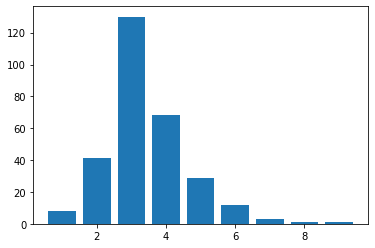

In [24]:
# interaction round of every sample
data = dev.get_interaction_num()
data.describe().round(2)
value_count = data.value_counts()
plt.bar(value_count.keys(),value_count)
plt.show()

In [25]:
# number of toks of every utterance/query
data = dev.get_utter_query_toks_len()
data.describe().round(2)

,utter_tok_num,query_tok_num
count,1007.00,1007.00
mean,12.35,18.19
std,7.34,14.03
min,3.00,4.00
25%,7.50,8.00
50%,10.00,12.00
75%,15.00,27.00
max,55.00,122.00


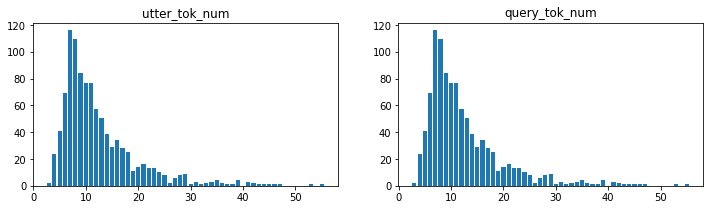

In [26]:
value_count = [data[key].value_counts() for key in data.keys()]
plt.figure(figsize=(12,3))
for i in range(len(data.keys())):
    ax = plt.subplot(121+i)
    ax.set_title(data.keys()[i])
    plt.bar(value_count[0].keys(),value_count[0])
plt.show();

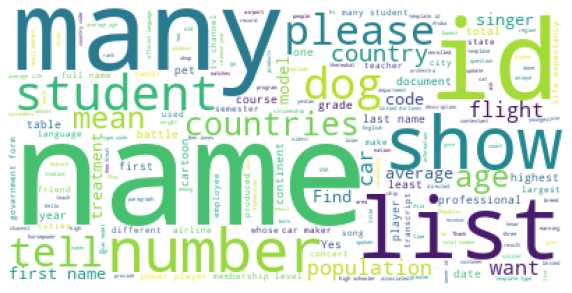

In [27]:
# utterance wordcloud
data = dev.get_all_utter()
wordcloud = WordCloud(background_color="white").generate(data)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

## Training dataset

In [49]:
train = SQL_State("sql_state_tracking\cosql_train.json")
# sample amount
train.count

2159

In [29]:
# database_id occurence count
train.get_dbid().value_counts()

college_1                 53
college_2                 53
department_store          44
store_1                   43
baseball_1                39
                          ..
performance_attendance     5
e_government               5
workshop_paper             4
company_1                  2
music_2                    1
Length: 140, dtype: int64

count    2159.00
mean        3.40
std         1.12
min         1.00
25%         3.00
50%         3.00
75%         4.00
max        10.00
dtype: float64

<BarContainer object of 10 artists>

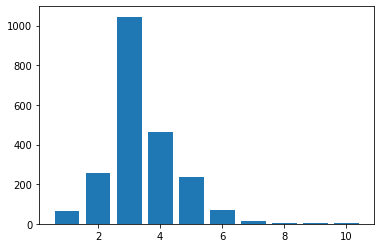

In [30]:
# interaction round of every sample
data = train.get_interaction_num()
data.describe().round(2)
value_count = data.value_counts()
plt.bar(value_count.keys(),value_count)
plt.show()

In [31]:
# number of toks of every utterance/query
data = train.get_utter_query_toks_len()
data.describe().round(2)

,utter_tok_num,query_tok_num
count,7343.00,7343.00
mean,12.86,18.38
std,7.81,13.49
min,1.00,4.00
25%,8.00,8.00
50%,10.00,12.00
75%,15.00,27.00
max,72.00,125.00


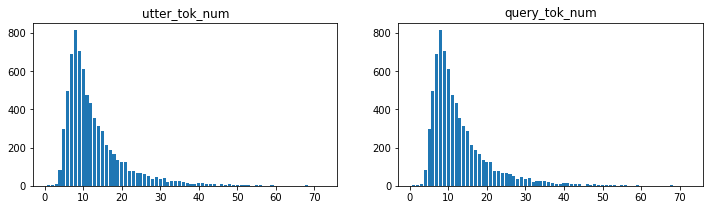

In [32]:
value_count = [data[key].value_counts() for key in data.keys()]
plt.figure(figsize=(12,3))
for i in range(len(data.keys())):
    ax = plt.subplot(121+i)
    ax.set_title(data.keys()[i])
    plt.bar(value_count[0].keys(),value_count[0])
plt.show();

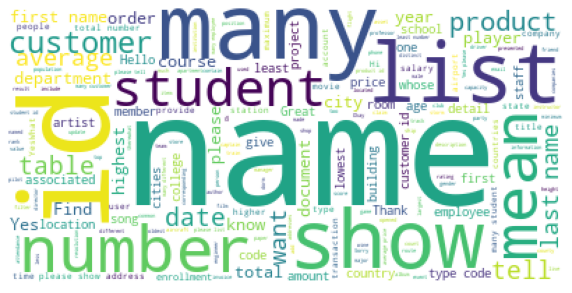

In [33]:
# utterance wordcloud
data = train.get_all_utter()
wordcloud = WordCloud(background_color="white").generate(data)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# System Response Generation

In [13]:
class System_Response:

    keys = ["database_id", "query", "query_toks", "results_raw", "results_map", "results_blank_res",\
            "query_w_results", "query_w_results_blank_res", "query_toks_w_results", "query_toks_w_results_blank_res",\
            "response", "response_toks","response_blank_res", "response_toks_blank_res"]
    
    def __init__(self, filename):
        with open(filename, 'r') as f:
            self.lst = json.load(f)
        self.count = len(self.lst)
    
    def get_missing_count(self):
        missing_count = dict()
        for k in self.keys:
            missing_count[k] = 0
        for data in self.lst:
            for k in self.keys:
                if data[k] == None:
                    missing_count[k] += 1
        return pd.Series(missing_count)
        
    def get_dbid(self): # Get all database_id
        dbid = []
        for data in self.lst:
            dbid.append(data["database_id"])
        return pd.Series(dbid)
    
    def get_result_num(self): # Get all result_num
        result_num = []
        for data in self.lst:
            try:
                result_num.append(len(data["results_map"]))
            except: pass # results_map = null
        return pd.Series(result_num)

    def get_response_query_toks_len(self): # Get all response_query_toks_len
        toks_cat = ["query_toks_num","query_toks_w_results_num","query_toks_w_results_blank_res_num",\
                    "response_toks_num","response_toks_blank_res_num"]
        dt = {tok: [] for tok in toks_cat}
        for data in self.lst:
            for tok in toks_cat:
                try:
                    dt[tok].append(len(data[tok[:-4]]))
                except: dt[tok].append(None) # missing value
        return pd.DataFrame.from_dict(dt)

    def get_all_response(self): # Get all response
        responses = ""
        for data in self.lst:
            responses += data["response"]
        return responses

## Development dataset

In [14]:
dev = System_Response(f"{PATH_TO_COSQL}/system_response_generation/cosql_dev.json")
# sample amount
dev.count

1074

In [36]:
# missing values acount for each column
dev.get_missing_count().sort_values(ascending=False)

results_map                       28
results_blank_res                 28
query_w_results                   28
query_w_results_blank_res         28
query_toks_w_results              28
query_toks_w_results_blank_res    28
response_blank_res                28
response_toks_blank_res           28
results_raw                        5
database_id                        0
query                              0
query_toks                         0
response                           0
response_toks                      0
dtype: int64

In [37]:
# database_id occurence count
dev.get_dbid().value_counts()

world_1                         139
dog_kennels                     108
car_1                           105
student_transcripts_tracking     91
flight_2                         64
wta_1                            61
network_1                        58
concert_singer                   53
cre_Doc_Template_Mgt             52
museum_visit                     49
pets_1                           46
tvshow                           45
poker_player                     43
employee_hire_evaluation         35
battle_death                     32
singer                           28
course_teach                     25
orchestra                        20
voter_1                          11
real_estate_properties            9
dtype: int64

In [38]:
dev.get_result_num().value_counts()

0    535
1    460
2     41
3      8
4      2
dtype: int64

In [39]:
# number of toks of every utterance/response
data = dev.get_response_query_toks_len()
data.describe().round(2)

,query_toks_num,query_toks_w_results_num,query_toks_w_results_blank_res_num,response_toks_num,response_toks_blank_res_num
count,1074.00,1046.00,1046.00,1074.00,1046.00
mean,18.54,18.99,18.99,13.20,13.24
std,14.06,13.90,13.90,5.53,5.56
min,4.00,4.00,4.00,1.00,1.00
25%,8.00,9.00,9.00,10.00,10.00
50%,12.00,13.00,13.00,12.00,12.00
75%,27.00,28.00,28.00,16.00,16.00
max,122.00,122.00,122.00,41.00,41.00


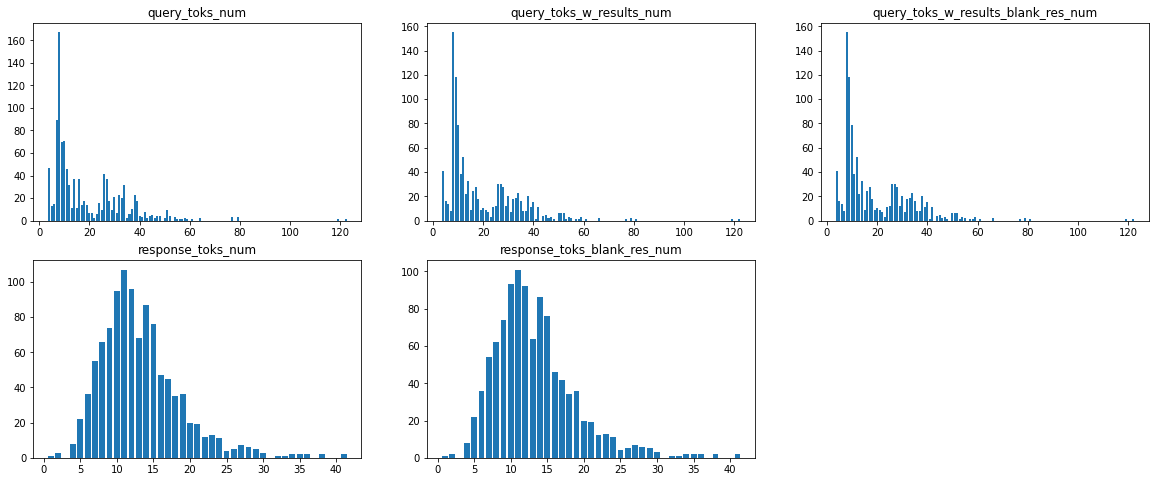

In [40]:
value_count = [data[key].value_counts() for key in data.keys()]
plt.figure(figsize=(20,8))
for i in range(len(data.keys())):
    ax = plt.subplot(231+i)
    ax.set_title(data.keys()[i])
    plt.bar(value_count[i].keys(),value_count[i])

plt.show();

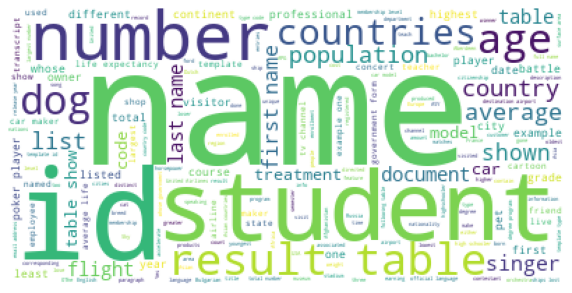

In [41]:
# response wordcloud
data = dev.get_all_response()
wordcloud = WordCloud(background_color="white").generate(data)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

## Training dataset

In [15]:
train = System_Response(f"{PATH_TO_COSQL}/system_response_generation/cosql_train.json")
# sample amount
train.count

7845

In [43]:
# missing values acount for each column
train.get_missing_count().sort_values(ascending=False)

results_map                       185
results_blank_res                 185
query_w_results                   185
query_w_results_blank_res         185
query_toks_w_results              185
query_toks_w_results_blank_res    185
response_blank_res                185
response_toks_blank_res           185
results_raw                        22
database_id                         0
query                               0
query_toks                          0
response                            0
response_toks                       0
dtype: int64

In [44]:
# database_id occurence count
train.get_dbid().value_counts()

college_2                 188
college_1                 188
store_1                   167
department_store          161
network_2                 151
                         ... 
pilot_record               17
performance_attendance     17
workshop_paper             13
company_1                   7
music_2                     2
Length: 140, dtype: int64

In [45]:
train.get_result_num().value_counts()

0    4015
1    3209
2     350
3      59
4      19
6       5
5       2
7       1
dtype: int64

In [46]:
# number of toks of every utterance/response
data = train.get_response_query_toks_len()
data.describe().round(2)

,query_toks_num,query_toks_w_results_num,query_toks_w_results_blank_res_num,response_toks_num,response_toks_blank_res_num
count,7845.00,7660.00,7660.00,7845.00,7660.00
mean,18.79,19.13,19.13,13.80,13.81
std,13.65,13.46,13.46,6.01,6.03
min,4.00,4.00,4.00,1.00,1.00
25%,8.00,9.00,9.00,10.00,10.00
50%,13.00,13.00,13.00,13.00,13.00
75%,27.00,28.00,28.00,17.00,17.00
max,127.00,129.00,129.00,67.00,67.00


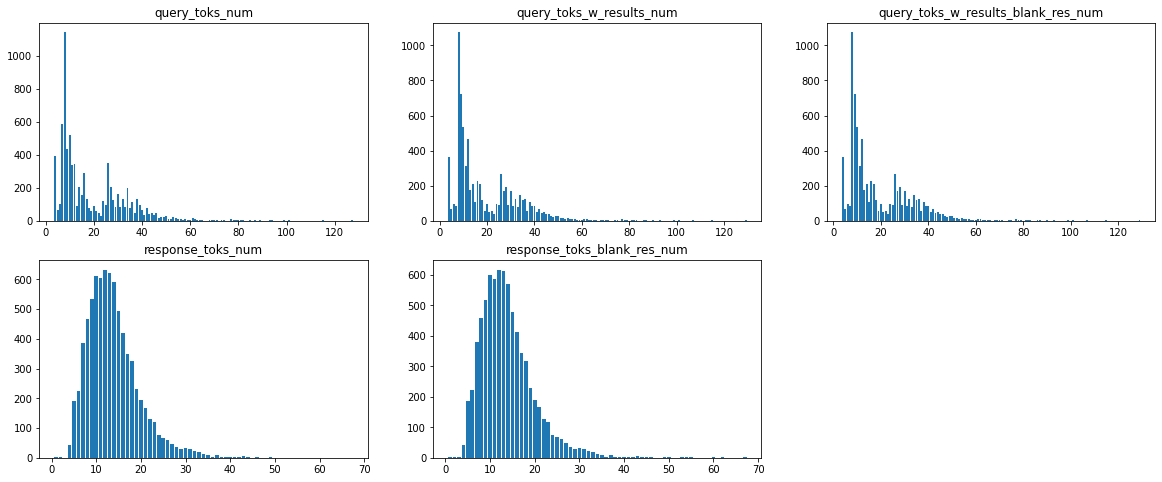

In [47]:
value_count = [data[key].value_counts() for key in data.keys()]
plt.figure(figsize=(20,8))
for i in range(len(data.keys())):
    ax = plt.subplot(231+i)
    ax.set_title(data.keys()[i])
    plt.bar(value_count[i].keys(),value_count[i])

plt.show();

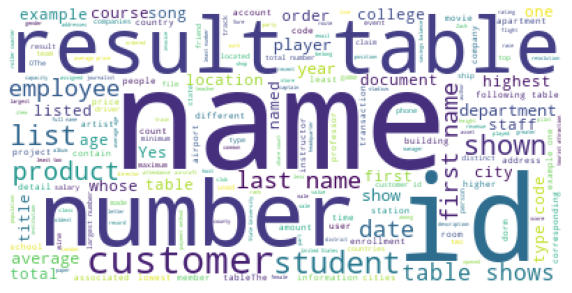

In [48]:
# response wordcloud
data = train.get_all_response()
wordcloud = WordCloud(background_color="white").generate(data)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();